#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [45]:
df_stock1 = pd.read_csv("../static/data/csl.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df.iloc[:-1,:]
df.tail()   

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
5746,27/07/2022,288.179993,293.299988,287.019989,291.829987,291.829987,440959.0,1.35,2.5,125.0
5747,28/07/2022,293.709991,294.190002,289.149994,291.399994,291.399994,647711.0,1.35,2.5,125.0
5748,29/07/2022,294.010010,295.290009,289.839996,289.839996,289.839996,1141755.0,1.35,2.5,125.0
5749,1/08/2022,288.649994,295.480011,288.649994,294.910004,294.910004,629744.0,1.35,2.5,125.0
5750,2/08/2022,295.209991,297.980011,293.440002,296.850006,296.850006,566982.0,1.35,2.5,125.0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5716 entries, 0 to 5750
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5716 non-null   object 
 1   Open       5716 non-null   float64
 2   High       5716 non-null   float64
 3   Low        5716 non-null   float64
 4   Close      5716 non-null   float64
 5   Adj Close  5716 non-null   float64
 6   Volume     5716 non-null   float64
 7   RBA        5716 non-null   float64
 8   FED        5716 non-null   float64
 9   CPI        5716 non-null   float64
dtypes: float64(9), object(1)
memory usage: 491.2+ KB


In [47]:
#Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# # Drop all previous records now in MongoDb
# db.csl.drop()

# # Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.csl.insert_many(records)


In [48]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.csl.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.csl.delete_one(
    {'Date': last_date}
)


DELETE: 2/08/2022 296.850006


In [49]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.csl.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 1/08/2022 294.910004
Previous last date in MongoDb: 01-08-2022. Today's date: 03-08-2022


In [50]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'CSL.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-02,297.980011,293.440002,295.209991,296.850006,566982,296.850006


In [51]:
tot=len(stock_quote)
rba=1.35
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)

#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)

stock_quote

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,02/08/2022,297.980011,293.440002,295.209991,296.850006,566982,296.850006,1.35,2.5,125


In [52]:
records=stock_quote.to_dict('records')
records

[{'Date': '02/08/2022',
  'High': 297.9800109863281,
  'Low': 293.44000244140625,
  'Open': 295.2099914550781,
  'Close': 296.8500061035156,
  'Volume': 566982,
  'Adj Close': 296.8500061035156,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125}]

In [53]:
#INSERT NEW DATA INTO MONGODB
db.csl.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.csl.find()))

last_val = df_mongo.iloc[-10:].values
print(last_val)

[[ObjectId('62e9af15b1e6f1858d541dab') '20/07/2022' 292.540009 293.970001
  288.630005 291.230011 291.230011 660120.0 1.35 1.75 125.0]
 [ObjectId('62e9af15b1e6f1858d541dac') '21/07/2022' 293.269989 295.380005
  291.399994 295.23999 295.23999 817999.0 1.35 1.75 125.0]
 [ObjectId('62e9af15b1e6f1858d541dad') '22/07/2022' 294.399994 296.5
  291.519989 293.470001 293.470001 1505471.0 1.35 1.75 125.0]
 [ObjectId('62e9af15b1e6f1858d541dae') '25/07/2022' 295.0 296.320007
  289.809998 291.0 291.0 599426.0 1.35 1.75 125.0]
 [ObjectId('62e9af15b1e6f1858d541daf') '26/07/2022' 289.769989 290.0
  285.220001 286.75 286.75 519181.0 1.35 1.75 125.0]
 [ObjectId('62e9af15b1e6f1858d541db0') '27/07/2022' 288.179993 293.299988
  287.019989 291.829987 291.829987 440959.0 1.35 2.5 125.0]
 [ObjectId('62e9af15b1e6f1858d541db1') '28/07/2022' 293.709991 294.190002
  289.149994 291.399994 291.399994 647711.0 1.35 2.5 125.0]
 [ObjectId('62e9af15b1e6f1858d541db2') '29/07/2022' 294.01001 295.290009
  289.839996 289.8

In [54]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

02/08/2022 296.8500061035156


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [55]:
df_mongo = pd.DataFrame(list(db.csl.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape
len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(5716, 1)

In [56]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape

In [57]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4573, 1)

In [58]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.01017412, 0.00983794, 0.00974402, 0.00928425, 0.00883932,
       0.01027299, 0.01022355, 0.01047074, 0.01037186, 0.01072781,
       0.01096511, 0.01091567, 0.01096511, 0.01141004, 0.01101454,
       0.01086623, 0.01081581, 0.01145948, 0.01126173, 0.01135368,
       0.01145948, 0.01150891, 0.01154846, 0.01155835, 0.01160779,
       0.01096511, 0.01111342, 0.01126173, 0.01056961, 0.01041141,
       0.01037186, 0.01003569, 0.00937719, 0.00899653, 0.00903707,
       0.00898763, 0.00898763, 0.00943256, 0.00933369, 0.009482  ,
       0.01007524, 0.00999515, 0.009482  , 0.00862773, 0.00918538,
       0.00928425, 0.00898763, 0.00903707, 0.0097806 , 0.00997637,
       0.00997637, 0.00997637, 0.01037186, 0.01032243, 0.01039362,
       0.01056961, 0.01066848, 0.01047074, 0.01027299, 0.01047074])]
[0.010477658470026397]


# Prepare train data for LSTM model

In [59]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4513, 60)

In [60]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4513, 60, 1)

# Build the LSTM model

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [62]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [63]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4513/4513 [==============================] - 67s 15ms/step - loss: 1.6393e-04


In [64]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [65]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [66]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [67]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

7.2976556265857395

C:\Users\antoi\AppData\Local\Temp/ipykernel_14260/1751790871.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


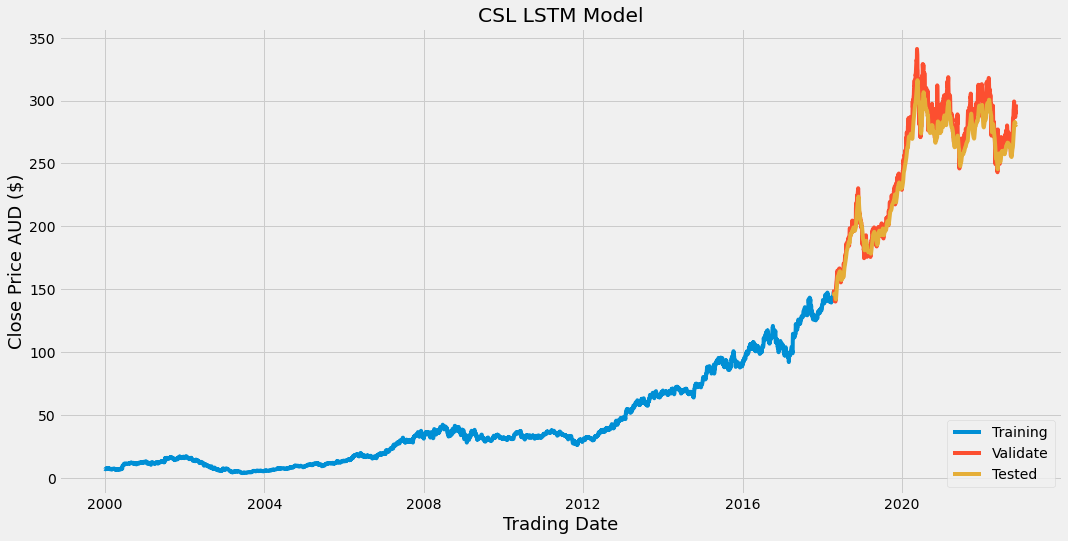

In [68]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('CSL LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/csl_graph.png')
plt.show()


# Test data Predictions on the Model

In [69]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_14260/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4573,149.839996,144.654999,5.184997
4574,147.500000,145.595551,1.904449
4575,146.419998,146.189926,0.230072
4576,146.009995,146.429138,-0.419143
4577,147.289993,146.426468,0.863525
...,...,...,...
5711,291.829987,281.382843,10.447144
5712,291.399994,280.995453,10.404541
5713,289.839996,280.778290,9.061706
5714,294.910004,280.482239,14.427765


In [70]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.wbc.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [71]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [72]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

02/08/2022 Last close $296.8500061035156 Predicted next day share price $16.59


# Save the Model

In [73]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/csl_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list csl_sixty and load df

#PREDICT USING LOADED MODEL

In [74]:
from keras.models import load_model
model_in = load_model('../static/csl_model.sav')

In [75]:
# query the csl collection and load into dataframe
import pandas as pd

df_mongo = pd.DataFrame(list(db.csl.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[265.899994  ],
       [272.565002  ],
       [268.795013  ],
       [273.769989  ],
       [276.269989  ],
       [272.299988  ],
       [272.515015  ],
       [268.5       ],
       [272.540009  ],
       [270.019989  ],
       [270.589996  ],
       [272.049988  ],
       [269.799988  ],
       [268.070007  ],
       [269.079987  ],
       [271.829987  ],
       [271.690002  ],
       [267.179993  ],
       [267.549988  ],
       [269.049988  ],
       [265.299988  ],
       [267.        ],
       [270.540009  ],
       [270.049988  ],
       [256.        ],
       [257.100006  ],
       [257.619995  ],
       [254.300003  ],
       [257.559998  ],
       [257.570007  ],
       [260.065002  ],
       [262.329987  ],
       [267.380005  ],
       [270.049988  ],
       [270.725006  ],
       [265.76001   ],
       [267.970001  ],
       [268.269989  ],
       [271.450012  ],
       [275.049988  ],
       [276.5       ],
       [283.26001   ],
       [285.140015  ],
       [286

#Create a function to loop through the days input

In [76]:
from keras.models import load_model
model_in = load_model('../static/csl_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_csl(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_csl(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[288.01,
 288.02,
 287.88,
 287.66,
 287.41,
 287.14,
 286.88,
 286.63,
 286.38,
 286.15,
 285.92,
 285.7,
 285.48,
 285.28,
 285.08,
 284.89,
 284.7,
 284.52,
 284.35,
 284.18,
 284.02,
 283.86,
 283.7,
 283.55,
 283.4,
 283.26,
 283.12,
 282.98,
 282.99,
 282.87,
 282.87,
 282.86,
 282.9,
 282.85,
 282.81,
 282.77,
 282.79,
 282.77,
 282.8,
 282.8,
 282.79,
 282.64,
 282.62,
 282.59,
 282.55,
 282.52,
 282.48,
 282.44,
 282.42,
 282.38,
 282.35,
 282.31,
 282.28,
 282.24,
 282.21,
 282.17,
 282.13,
 282.1,
 282.06,
 282.03,
 282.07,
 282.05,
 282.03,
 282.01,
 281.99,
 281.98,
 281.97,
 281.95,
 281.94,
 281.93,
 281.92,
 281.91,
 281.9,
 281.89,
 281.89,
 281.88,
 281.87,
 281.86,
 281.86,
 281.85,
 281.85,
 281.84,
 281.84,
 281.83,
 281.83,
 281.83,
 281.83,
 281.82,
 281.82,
 281.82,
 281.81,
 281.81,
 281.81,
 281.8,
 281.8,
 281.8,
 281.79,
 281.79,
 281.79,
 281.78,
 281.78,
 281.78,
 281.78,
 281.78,
 281.77,
 281.77,
 281.77,
 281.77,
 281.77,
 281.76,
 281.76,
 281.76,
 281

In [77]:
import pandas as pd
dates_df = pd.read_csv("../static/data/dates.csv")
dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
dates_df

,Count,Date,DOW
0,1,11/07/2022,Monday
1,2,12/07/2022,Tuesday
2,3,13/07/2022,Wednesday
3,4,14/07/2022,Thursday
4,5,15/07/2022,Friday
...,...,...,...
260,261,10/07/2023,Monday
261,262,11/07/2023,Tuesday
262,263,12/07/2023,Wednesday
263,264,13/07/2023,Thursday


C:\Users\antoi\AppData\Local\Temp/ipykernel_14260/153595235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


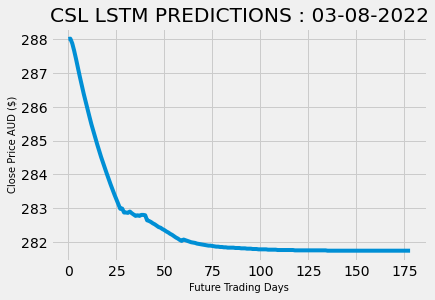

In [78]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:input-1]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('CSL LSTM PREDICTIONS : '+today)
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.savefig('../static/data/images/pred/csl_pred.png', bbox_inches="tight")
plt.show()



In [79]:

#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 288.01},
 {'Price': 288.02},
 {'Price': 287.88},
 {'Price': 287.66},
 {'Price': 287.41},
 {'Price': 287.14},
 {'Price': 286.88},
 {'Price': 286.63},
 {'Price': 286.38},
 {'Price': 286.15},
 {'Price': 285.92},
 {'Price': 285.7},
 {'Price': 285.48},
 {'Price': 285.28},
 {'Price': 285.08},
 {'Price': 284.89},
 {'Price': 284.7},
 {'Price': 284.52},
 {'Price': 284.35},
 {'Price': 284.18},
 {'Price': 284.02},
 {'Price': 283.86},
 {'Price': 283.7},
 {'Price': 283.55},
 {'Price': 283.4},
 {'Price': 283.26},
 {'Price': 283.12},
 {'Price': 282.98},
 {'Price': 282.99},
 {'Price': 282.87},
 {'Price': 282.87},
 {'Price': 282.86},
 {'Price': 282.9},
 {'Price': 282.85},
 {'Price': 282.81},
 {'Price': 282.77},
 {'Price': 282.79},
 {'Price': 282.77},
 {'Price': 282.8},
 {'Price': 282.8},
 {'Price': 282.79},
 {'Price': 282.64},
 {'Price': 282.62},
 {'Price': 282.59},
 {'Price': 282.55},
 {'Price': 282.52},
 {'Price': 282.48},
 {'Price': 282.44},
 {'Price': 282.42},
 {'Price': 282.38},
 {'Pric

In [80]:
# DRAW THE PREDICTION
# df_len = len(df.index) # length of the original dataframe
df_mongo_len=len(df_mongo)
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,df_mongo_len,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4573 5716 5896


,Close
5885,281.74
5886,281.74
5887,281.74
5888,281.74
5889,281.74
5890,281.74
5891,281.74
5892,281.74
5893,281.74
5894,281.74


C:\Users\antoi\AppData\Local\Temp/ipykernel_14260/1680629465.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


<Figure size 432x288 with 0 Axes>

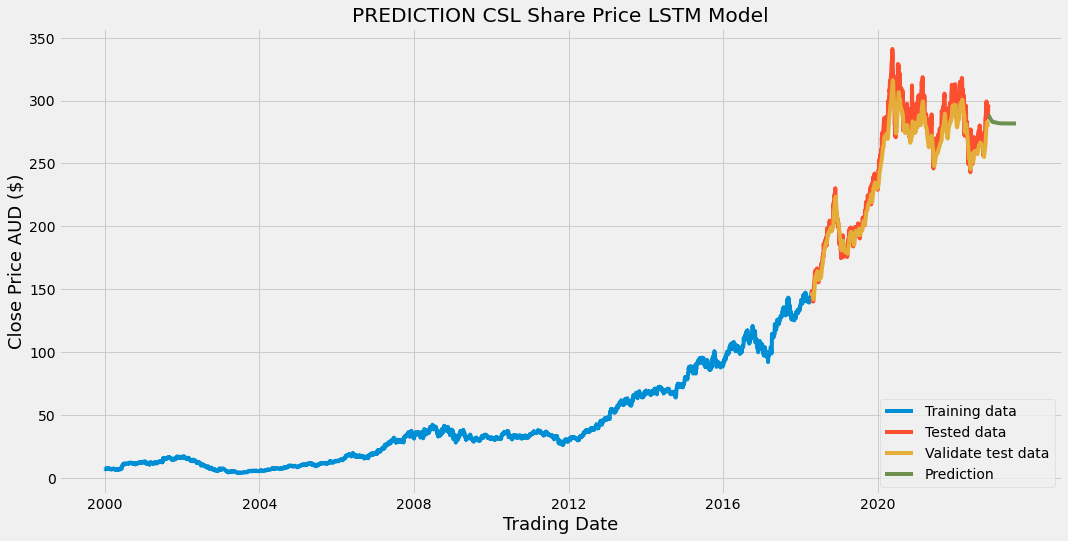

In [81]:
#Plot the data to validate the test data
plt.clf()
plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:df_mongo_len] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[df_mongo_len:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION CSL Share Price LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/csl_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [82]:
# Query all
# Here, db.companys refers to the collection 'companys '
name = 'CSL'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e47f0dd8ea1e501830cc74'), 'model': 'RFR', 'name': 'CSL', 'date': '28/07/2022', 'predicted': 244, 'actual': 289, 'differece': -44.766444751532276, 'accuracy': 96.25}
{'_id': ObjectId('62e9ae78b1e6f1858d54075f'), 'model': 'LSTM', 'name': 'CSL', 'date': '02/08/2022', 'predicted': 22.79, 'actual': 296.85, 'difference': -274.06, 'rmse': 0.79438}


In [83]:
# Delete a document from a collection
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e47f0dd8ea1e501830cc74'), 'model': 'RFR', 'name': 'CSL', 'date': '28/07/2022', 'predicted': 244, 'actual': 289, 'differece': -44.766444751532276, 'accuracy': 96.25}


In [84]:
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date}, predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 02/08/2022, predicted $16.59, actual $296.85, difference -280.26000000000005, rmse 7.29766


In [85]:
# Insert a document into the 'companys' collection
db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62e47f0dd8ea1e501830cc74'), 'model': 'RFR', 'name': 'CSL', 'date': '28/07/2022', 'predicted': 244, 'actual': 289, 'differece': -44.766444751532276, 'accuracy': 96.25}
{'_id': ObjectId('62e9af65b1e6f1858d541db6'), 'model': 'LSTM', 'name': 'CSL', 'date': '02/08/2022', 'predicted': 16.59, 'actual': 296.85, 'difference': -280.26, 'rmse': 7.29766}


In [86]:
# query all companys collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62df8ae0427af058c4334ede'), 'model': 'RFR', 'name': 'CBA', 'date': '26/07/2022', 'predicted': 97, 'actual': 96, 'differece': 1.0204273335669143, 'accuracy': 97.43}
{'_id': ObjectId('62dfa392f178c5283b8b5648'), 'model': 'RFR', 'name': 'MIN', 'date': '22/07/2022', 'predicted': 38, 'actual': 46, 'differece': -7.74920083942115, 'accuracy': 93.63}
{'_id': ObjectId('62dfa4d3643d249dfcfea5f3'), 'model': 'RFR', 'name': 'NAB', 'date': '26/07/2022', 'predicted': 28, 'actual': 29, 'differece': -0.9521357946721061, 'accuracy': 97.23}
{'_id': ObjectId('62e230eafd3e48eabe9b8365'), 'model': 'RFR', 'name': 'WBC', 'date': '28/07/2022', 'predicted': 31, 'actual': 21, 'differece': 10.425907785164608, 'accuracy': 97.16}
{'_id': ObjectId('62e236dd0512e77444960bd6'), 'model': 'RFR', 'name': 'NIC', 'date': '28/07